In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import numpy as np
import pandas as pd
import re

from pathlib import Path

In [2]:
def extract_years(dates):
    # Extract the first and last years from a "dates_covered" string
    if pd.isna(dates):
        return (np.nan, np.nan)
    years = re.findall(r"\b\d{4}\b", str(dates))
    if len(years) < 2:
        return (np.nan, np.nan)
    return int(years[0]), int(years[1])

In [3]:
# Set paths 
root_p = Path("/Users/natashaclarke/winrepo/funders_project")
data_p = root_p / "data"
stats_p = data_p / "FundingAgencyStats - full_eu_breakdown_analysis.csv"
figures_p = root_p / "figures"
figures_p.mkdir(parents=True, exist_ok=True)

In [4]:
# Load data
df = pd.read_csv(stats_p)

In [5]:
df.columns

Index(['checked since 09/2025', 'researcher', 'category', 'country', 'funder',
       'data_type', 'dates_covered', 'findable', 'tabular',
       'data_downloadable', '>=3 years data', 'neuro_specific', 'gender',
       'age_or_career_stage', 'summary_funding', 'per_group_funding',
       'grant_duration', 'year_of_award', 'dei_eo_page', 'parental_leave',
       'english_data', 'report_all_applicants', 'total_score',
       'report_winners', 'age', 'career_stage', 'disability', 'ethnicity',
       'osf_file', 'notes'],
      dtype='object')

In [6]:
# Total unique countries
num_countries = df['country'].nunique()

# Total unique funders
num_funders = df['funder'].nunique()

# How many funders have data
funder_max = df.groupby('funder').agg({
    'findable': 'max',
}).reset_index()
num_funders_with_data = (funder_max['findable'] == 1).sum()

print(f"Countries: {num_countries}")
print(f"Funders total: {num_funders}")
print(f"Funders with data: {num_funders_with_data}")

Countries: 33
Funders total: 39
Funders with data: 35


In [7]:
# Get the frequency of each data type
data_type_counts = df['data_type'].value_counts().reset_index()

# Rename the columns for clarity
data_type_counts.columns = ['data_type', 'count']

# Calculate percentages
data_type_counts['percentage'] = (data_type_counts['count'] / data_type_counts['count'].sum()) * 100
data_type_counts

,data_type,count,percentage
0,annual_report,19,37.254902
1,tabular,11,21.568627
2,portal,10,19.607843
3,list,6,11.764706
4,report,5,9.803922


In [8]:
# Calculate the widest range of data available per funder
# Extract start and end of funding years
df[["start_year", "end_year"]] = (df["dates_covered"].apply(extract_years).apply(pd.Series))
df["start_year"] = df["start_year"].astype("Int64")
df["end_year"] = df["end_year"].astype("Int64")
df.sort_values("start_year").head()

,checked since 09/2025,researcher,category,country,funder,data_type,dates_covered,findable,tabular,data_downloadable,...,total_score,report_winners,age,career_stage,disability,ethnicity,osf_file,notes,start_year,end_year
13,Y,NC,EU member,Denmark,Novo Nordisk Foundation (Denmark),portal,1963-2026,1,0.0,0.0,...,6,1.0,0.0,0.0,0.0,0.0,NaN,NaN,1963,2026
31,Y,DP,EU member,Netherlands,Dutch Research Council,portal,1993-2026,1,0.0,0.0,...,7,1.0,0.0,0.0,0.0,0.0,Projectendatabank | NWO,NaN,1993,2026
0,Y,PM,EU member,Austria,Austrian Science Fund,tabular,1995-2025,1,1.0,1.0,...,11,1.0,0.0,1.0,0.0,0.0,/Austria - FWF/PI-projects....csv + annual rep...,NaN,1995,2025
24,Y,PM,EU member,Italy,Research Projects of National Relevance (Italy),list,1999-2022,1,0.0,1.0,...,10,1.0,0.0,1.0,0.0,0.0,"N/A, list online (see https://prin.mur.gov.it/)",NaN,1999,2022
20,Y,PM,EU member,Germany,German Research Foundation,portal,1999-2025,1,0.0,0.0,...,8,1.0,0.0,1.0,0.0,0.0,NaN,NaN,1999,2025


In [9]:
cols = [
    "findable","tabular","data_downloadable",">=3 years data",
    "neuro_specific","age","gender","disability","ethnicity","career_stage",
    "summary_funding","per_group_funding","grant_duration","year_of_award",
    "dei_eo_page","parental_leave","english_data","report_all_applicants",
    "age_or_career_stage"
]

# Collapse funders to their max values
funder_max = df.groupby('funder')[cols].max().reset_index()

# Compute percentages
percentages = (funder_max[cols].sum() / len(funder_max) * 100).sort_values(ascending=False)
percentages_df = percentages.reset_index()
percentages_df.columns = ['Measure', 'Percent_of_Funders']

percentages_df

,Measure,Percent_of_Funders
0,findable,89.743590
1,>=3 years data,82.051282
2,year_of_award,76.923077
3,data_downloadable,71.794872
4,english_data,71.794872
5,summary_funding,66.666667
6,age_or_career_stage,64.102564
7,gender,58.974359
8,career_stage,58.974359
9,per_group_funding,56.410256


In [10]:
# keep only the row with the highest total_score per funder
best_df = df.sort_values("total_score", ascending=False).drop_duplicates("funder")

In [11]:
def tier_color(score):
    if 1 <= score <= 8:
        return "peru"      
    elif 9 <= score <= 12:
        return "silver"    
    else:
        return "gold"

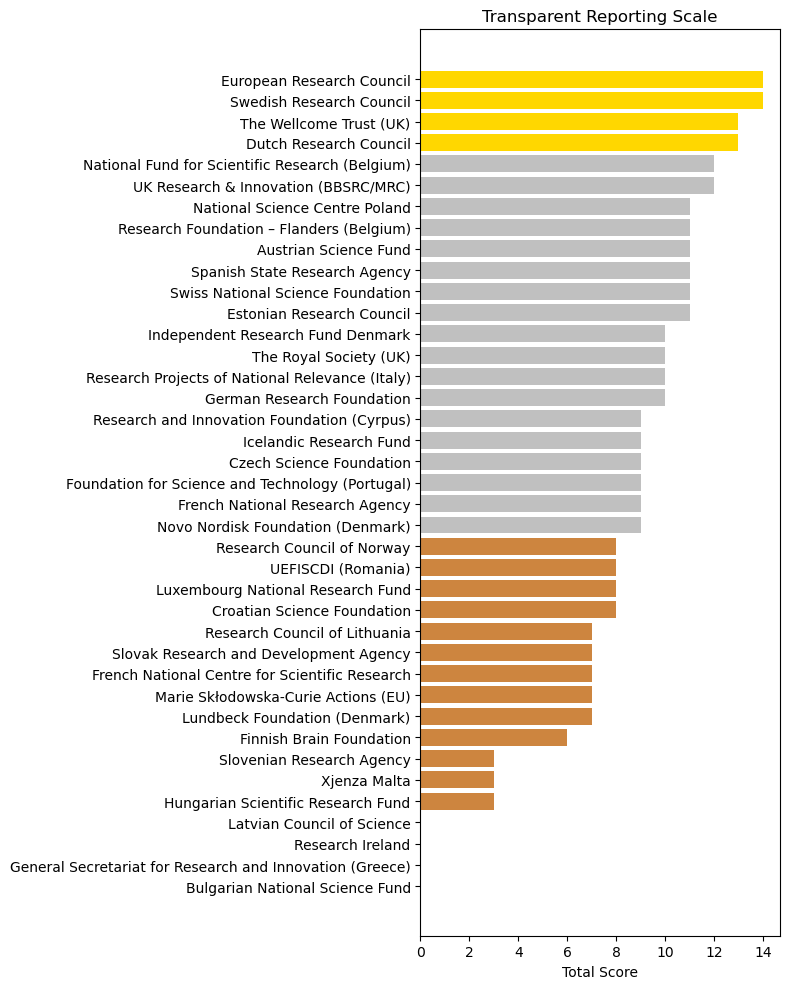

In [12]:
best_df = best_df.sort_values("total_score").dropna(subset=["funder"])

# assign colors
best_df["color"] = best_df["total_score"].apply(tier_color)

plt.figure(figsize=(8, 10))
plt.barh(
    best_df["funder"].astype(str),
    best_df["total_score"],
    color=best_df["color"]
)

plt.xlabel("Total Score")
plt.title("Transparent Reporting Scale")
plt.tight_layout()
plt.savefig(figures_p / "scale_results.png",dpi=300)
plt.show()

In [13]:
# Drop rows with no years
years_df = df.dropna(subset=["start_year"]).copy()

# Create the range of years for each funder
years_df["years_range"] = years_df.apply(lambda row: list(range(int(row["start_year"]), int(row["end_year"]) + 1)), axis=1)

# Expand into one row per year
years_df = years_df.explode("years_range").rename(columns={"years_range": "year"})

# Count unique funders per year
yearly_counts = years_df.groupby("year")["funder"].nunique().reset_index()

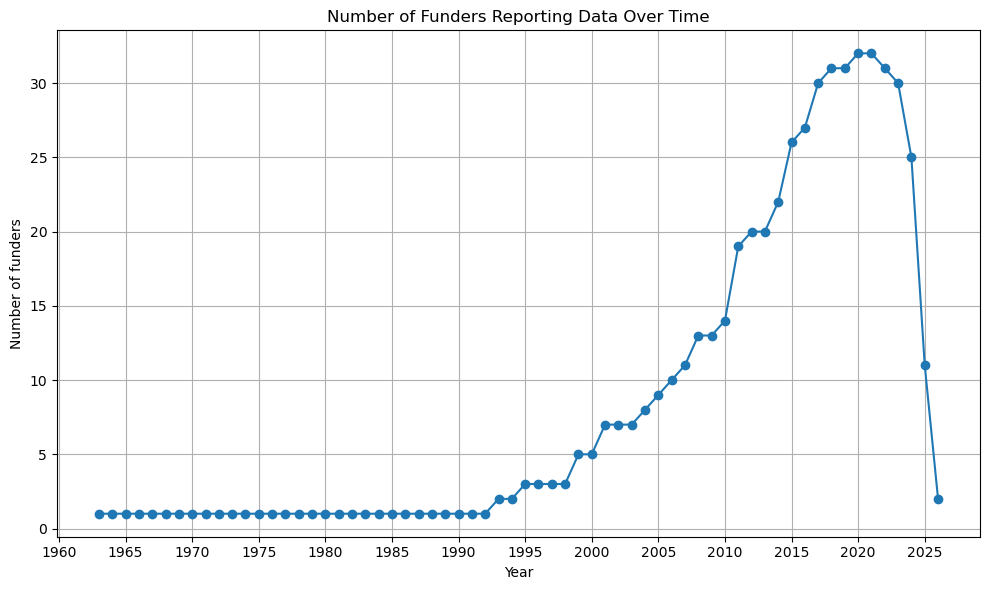

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(yearly_counts["year"], yearly_counts["funder"], marker="o")
plt.title("Number of Funders Reporting Data Over Time")
plt.xlabel("Year")
plt.ylabel("Number of funders")
plt.grid(True)
plt.xticks(ticks=range(1960, 2026, 5))
#plt.yticks(ticks=range(1, 16, 2))
plt.tight_layout()
plt.savefig(figures_p / "funding_over_time.png",dpi=300)
plt.show()

In [15]:
funders_per_country = df.groupby('country')['funder'].nunique().reset_index() 
funders_per_country.columns = ['country', 'num_funders'] 
funders_per_country['country'] = funders_per_country['country'].replace('UK', 'United Kingdom') 
funders_per_country.head()

,country,num_funders
0,Austria,1
1,Belgium,2
2,Bulgaria,1
3,Croatia,1
4,Czech Republic,1


In [16]:
# Load data from Natural Earth, to create a map
world = gpd.read_file(data_p / "geo_data/ne_110m_admin_0_countries.shp")
#print(world.columns.tolist())
europe = world[world['CONTINENT'] == 'Europe']
europe.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
18,Admin-0 country,1,2,Russia,RUS,0,2,Sovereign country,1,Russia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((178.7253 71.0988, 180 71.51571..."
21,Admin-0 country,1,3,Norway,NOR,0,2,Sovereign country,None,Norway,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
43,Admin-0 country,1,2,France,FR1,1,2,Country,1,France,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-51.6578 4.15623, -52.24934 3...."
110,Admin-0 country,1,3,Sweden,SWE,0,2,Sovereign country,1,Sweden,...,None,None,None,None,None,None,None,None,None,"POLYGON ((11.02737 58.85615, 11.46827 59.43239..."
111,Admin-0 country,1,4,Belarus,BLR,0,2,Sovereign country,1,Belarus,...,None,None,None,None,None,None,None,None,None,"POLYGON ((28.17671 56.16913, 29.22951 55.91834..."


In [17]:
# Merge the funders data with the Europe geo data
merged = europe.merge(funders_per_country, how='left', left_on='SOVEREIGNT', right_on='country')

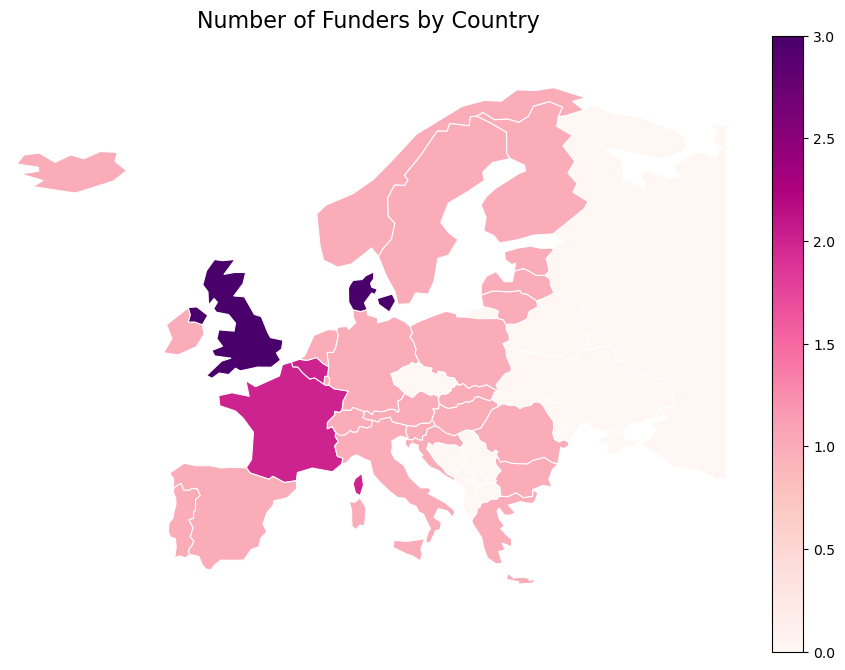

In [18]:
merged["num_funders"] = merged["num_funders"].fillna(0)

# Plot the map with a color gradient based on the number of funders
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(
    column='num_funders',  
    cmap='RdPu',          
    linewidth=0.8,          
    edgecolor='white',      
    legend=True,            
    ax=ax
)

# Zoom in using longtude and latitude ranges for Europe
ax.set_xlim([-25, 45])  
ax.set_ylim([30, 75])

"""
# Add labels for countries with data only
for idx, row in merged.iterrows():
    if row['num_funders'] > 0: 
        # Get the centroid of the country for label placement
        point = row['geometry'].representative_point()
        ax.annotate(
            text=row['SOVEREIGNT'], 
            xy=(point.x, point.y),
            ha='center', fontsize=10, color='grey')
"""

ax.set_title('Number of Funders by Country', fontdict={'fontsize': 16})
ax.set_axis_off()
plt.savefig(figures_p / "funders_map.png",dpi=300)
plt.show()

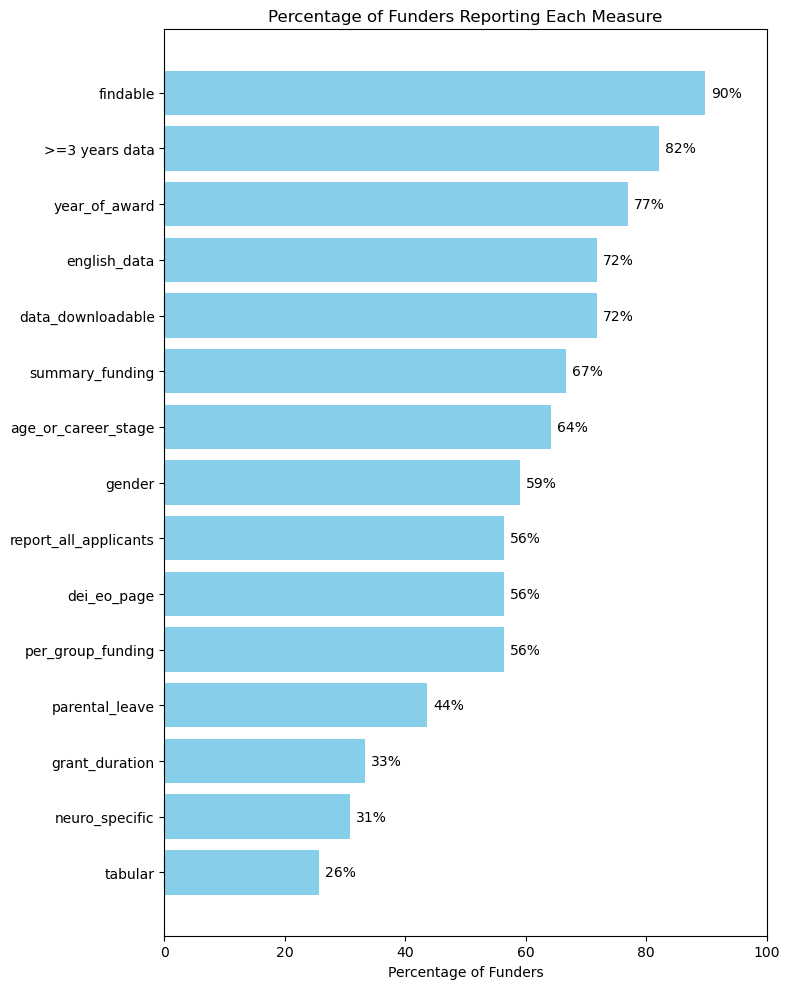

In [19]:
# create plot with a reduced number of columns

cols = [
    "findable","tabular","data_downloadable",">=3 years data",
    "neuro_specific","gender", "age_or_career_stage",
    "summary_funding","per_group_funding","grant_duration","year_of_award",
    "dei_eo_page","parental_leave","english_data","report_all_applicants",  
]

# Collapse funders to their max values
funder_max = df.groupby('funder')[cols].max().reset_index()

# Compute percentages
percentages = (funder_max[cols].sum() / len(funder_max) * 100).sort_values(ascending=False)
percentages_df = percentages.reset_index()
percentages_df.columns = ['Measure', 'Percent_of_Funders']

percentages_df = percentages_df.sort_values("Percent_of_Funders", ascending=True)

plt.figure(figsize=(8, 10))
bars = plt.barh(percentages_df["Measure"], percentages_df["Percent_of_Funders"], color="skyblue")

# Add percentage labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,f"{width:.0f}%", va='center')

plt.xlabel("Percentage of Funders")
plt.title("Percentage of Funders Reporting Each Measure")
plt.xlim(0, 100)
plt.tight_layout()
plt.savefig(figures_p / "percentages_plot.png",dpi=300)
plt.show()